# **`flygym`-MuJoCo tutorial:** Decentralized controller

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_decentralized_ctrl_basic.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to read the following pages on the documentation before proceeding with this tutorial:
- [The NeuroMechFly Model](https://nely-epfl.github.io/flygym/neuromechfly.html)
- [Interacting with an Environment](https://nely-epfl.github.io/flygym/environments/index.html)
- [The former demo on basic control](https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_sinewave.ipynb)
- [The former demo on kinematic replay]()

In [9]:
"""
#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym
"""

'\n#@title Install `flygym` on Colab\n\n# This block is modified from dm_control\'s tutorial notebook\n# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb\n\nimport subprocess\nif subprocess.run(\'nvidia-smi\').returncode:\n    raise RuntimeError(\n        \'Cannot communicate with GPU. \'\n        \'Make sure you are using a GPU Colab runtime. \'\n        \'Go to the Runtime menu and select Choose runtime type.\')\n\nprint(\'Installing flygym\')\n!pip install -q --progress-bar=off \'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git\'\n\n# Configure dm_control to use the EGL rendering backend (requires GPU)\n%env MUJOCO_GL=egl\n\nprint(\'Checking that the dm_control installation succeeded...\')\ntry:\n    from dm_control import suite\n    env = suite.load(\'cartpole\', \'swingup\')\n    pixels = env.physics.render()\nexcept Exception as e:\n    raise e from RuntimeError(\n        \'Something went wrong during dm_control installation. Check the shell \'\n       

In [11]:
#installing flygym to use juypternotebook
import os
os.chdir('..')
import sys
path = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder
path = '/Users/lschwitt/flygym_adhesion-Laetitia'
os.chdir(path)
sys.path.append(path)

In [12]:
pip install -e ."[mujoco]

Obtaining file:///C:/Users/lschwitt/flygym_adhesion-Laetitia
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: flygym
    Found existing installation: flygym 0.0.1
    Uninstalling flygym-0.0.1:
      Successfully uninstalled flygym-0.0.1
  Running setup.py develop for flygym
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

import PIL.Image
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


---

This notebook demonstrates a simple controller based on decentralized control.

Few rules based on the observation on stick insects by [Cruse et al.](https://moodle.epfl.ch/pluginfile.php/2323895/course/section/241288/cruse-insect_walking.pdf) are enough to coordinate stepping and generate locomotion.

The rules proposed by Cruse et al. are:
1) Suppress lift-off to avoid static instability.
2) Facilitate early protraction to favour temporal coherence.
3) Enforce late protraction to maintain temporal coherence.
4) Aim touchdown location to exploit prior ‘knowledge’ about foothold.
5) Distribute propulsive force among the legs to share load efficiently.
6) Enforce a correction step to avoid stumbling due to leg placement errors.

In this notebook we will explore rules 1, 2 and 3. In particular we are interested in their sufficiency to generate locomotion on flat terrain. The additional rules are powerfull on complex terrain. 

Each leg influences a set of legs through those rules. The sheme of coupling is defined in

<img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/cruse_rules.png" alt="CruseRules" width="500"> <figcaption>Source: [M.Shilling, H.Cruse](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009362)</figcaption>

Similar to the previous demos, we start by initializing the simulation environment:

In [4]:
# Initialize simulation
run_time = 1
out_dir = Path('../decentralized_ctrl')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 300),
                  'friction': (friction, 0.005, 0.0001)}

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs)

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>] actuators _adhesion
[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion na

We then load the data generating single step in each leg

In [5]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

The data is in the form of a dictionary. Each key is a joint degree of freedom (Dof). The corresponding value is a time series of that DoF to generate a single step cycle (swing followed by stance). Additionally, there's a key `'meta'` that maps to some metadata of the recording:

In [8]:
print('Dict keys:', data.keys())
print('Length of time series:', data['joint_RFCoxa'])
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: [0.61922731 0.61871353 0.61819975 ... 0.63212368 0.6256755  0.61922731]
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.ipynb'}


In [9]:
# Interpolate 5x
num_steps_base = int(run_time / nmf.timestep)
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

In [10]:
run_time, num_steps_base, nmf.timestep, interp_step_duration, step_duration, 0.5/nmf.timestep

(1, 10000, 0.0001, 1278, 1278, 5000.0)

The dataset contains the joint angles that result in a full step (swing followed by stance). This data has been extracted from a thetered fly on a ball as in the [notebook on kinematic replay](https://github.com/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_replay.ipynb).

The joint angles were extracted in the following way:

1. Run kinematic replay of ball locomotion on flat terrain.
2. Monitor the Tarsus position and contact forces.
3. Select steps with the highest z elevation for each leg.
4. Segment the steps between two consecutive touchdowns.
5. Crop the steps to ensure equal length.
6. Interpolate the joint angles for a couple of timesteps to ensure smooth closure.

There are plenty of ways to generate such a dataset. Feel free to explore other possibilites. A good stepping dataset is the key to a good walking behavior. 

One could also train a network to execute a perfect step depending on the fly height, speed and exact leg position.

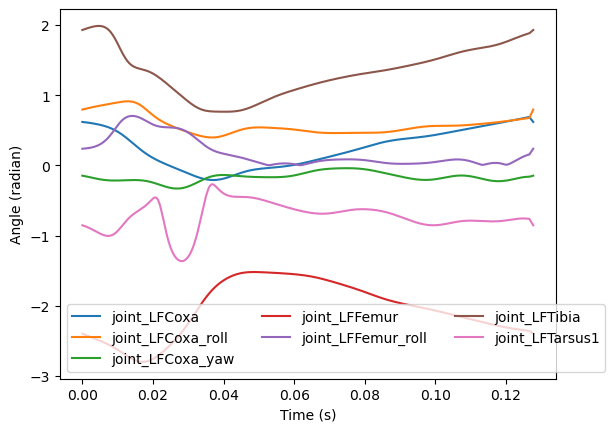

In [11]:
num_joints_to_visualize = 7
plt.plot(np.arange(step_data_block_base.shape[1]) * nmf.timestep,
         step_data_block_base[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend(ncol = 3)
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')
plt.show()

# Fine tuning of the stepping data

As explained before the step data was extracted from ball locomotion data. We are going to manually modify joint angles so that the load is evenly distributed in the resting pose and the fly stance looks more realitic.

### Base pose from ball data

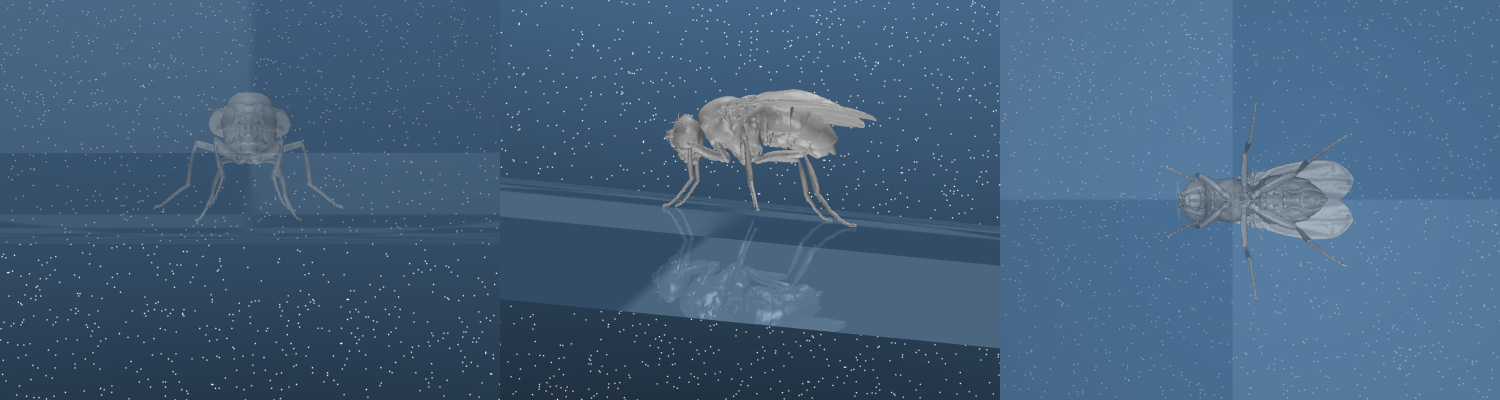

In [12]:
n_timesteps = 1000
for i in range(n_timesteps):
    action = {'joints': step_data_block_base[:, 0], 'adhesion': np.zeros(6)}
    _, _ = nmf.step(action)

all_viewpoints = []
h, w = 400, 500
for viewpoint in ['camera_front', 'camera_left', 'camera_bottom']:
    all_viewpoints.append(nmf.physics.render(camera_id=f"Animat/{viewpoint}", width=w, height=h))


im = PIL.Image.fromarray(np.hstack(all_viewpoints))
#show image
display(im)

### Manually restoring the balance

This pose is nowhere near the natural stance of a fly. From experience we can make a few observations:
- The fly is tilted forward. On flat terrain the fly has a more balanced stance or tends to lean slightly backward.
- The fly's middle leg are not touching the floor
- The hindleg's Tarsus should be more parallel to the floor


To allievate those issues, we will modify the joint angles aiming at:
1) Protracting the midlegs
2) Making the Tarsus more parallel to the floor
3) Retracting the hindlegs

Finally we should try to balance the contact forces across the 6 legs of the fly.

Rotation axis are defined as bellow

<img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/coords.png" alt="Rotation axis" width="500" style="background-color:white;">

In [13]:
step_data_block_manualcorrect = step_data_block_base.copy()

for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(13) # Protract the midlegs
    
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HCoxa")] -= np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTibia")] += np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    #step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTibia")] += np.deg2rad(0)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>]


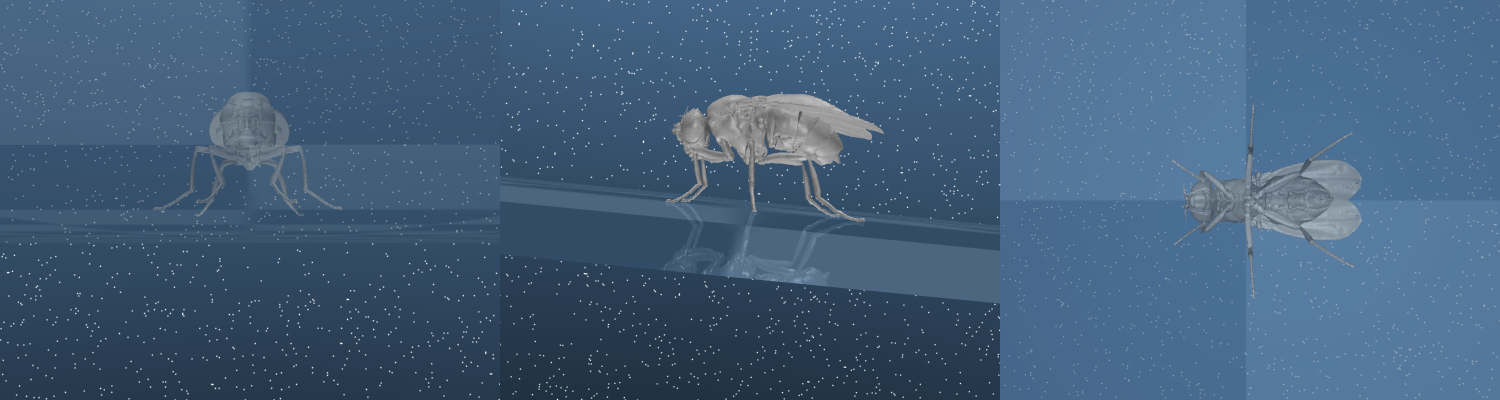

In [14]:
nmf.reset()

action = {'joints': step_data_block_manualcorrect[:, 0], 'adhesion': np.zeros(6)}
obs, _ = nmf.step(action)
i = 0
legs = ["RF", "LF", "RH", "LH", "RM", "LM"]
all_tarsus5_pos = {l:[] for l in legs}


# Run until the fly speed is less than 50 micron/sec or 50000 steps
while np.sum(np.abs(obs["fly"][1])) > 50 and i < 50000:
    action = {'joints': step_data_block_manualcorrect[:, 0], 'adhesion': np.zeros(6)}
    obs, _ = nmf.step(action)
    i += 1
    nmf.render()
   
# Keep track of the time it takes to stabilize
n_steps_stabil = i

nmf.save_video(out_dir / "video_initial_stance.mp4")
all_viewpoints = []
h, w = 400, 500
for viewpoint in ['camera_front', 'camera_left', 'camera_bottom']:
    all_viewpoints.append(nmf.physics.render(camera_id=f"Animat/{viewpoint}", width=w, height=h))

im = PIL.Image.fromarray(np.hstack(all_viewpoints))
#show concatenated image
display(im)

In [7]:
from ipywidgets import Video
Video.from_file(out_dir / 'video_initial_stance.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02<Nmdat\x00\x00\…

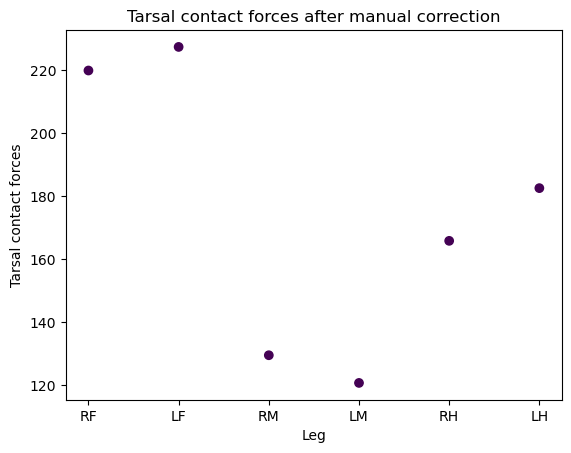

In [16]:
# Check load distribution from manual correction

legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)   

contact_forces = np.array([np.sum(obs["contact_forces"][leg_force_sensors_ids[leg]]) for leg in legs])
color = contact_forces <= 0
plt.scatter(np.arange(len(legs)), contact_forces, c=color)
plt.xticks(np.arange(len(legs)), legs)
plt.xlabel("Leg")
plt.ylabel("Tarsal contact forces")
plt.title("Tarsal contact forces after manual correction")
plt.show()

### Evaluate the step

Now that we have improved the resting pose of the fly, lets evaluate the step generated by the manually corrected joint angles.

In [17]:
import tensorflow as tf

# Set allow_growth option for the GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [18]:
nmf.reset()

legs = ["RH", "LH", "RF", "LF", "RM", "LM"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# Map the id of the end effector (Tarsus5) to the leg it belongs to
leg_to_end_effector_id = {leg:i for i, end_effector in enumerate(nmf.end_effector_names) for leg in legs if leg in end_effector if leg in end_effector}

# Number of timesteps between each (fly) step
n_rest_timesteps = 2000

# Map the id of the force sensors to the leg it belongs to
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg+"Tarsus"):
            leg_force_sensors_ids[leg].append(i)   

# Record the touch sensor data for each leg for each timepoint
touch_sensor_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1))

# Get the position of the last segment of the tarsus for each leg in the 
leg_tarsi_pos_id = {leg:[i] for leg in legs for i, joint in enumerate(nmf.actuated_joints) if leg in joint and "Tarsus1" in joint}
position_data = np.zeros((len(legs), interp_step_duration+n_rest_timesteps-1, 3))

# Run the simulation until the fly is stable
for k in range(n_steps_stabil):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0], 'adhesion': np.zeros(6)}
        obs, info = nmf.step(action)
        nmf.render()

# Lets step each leg on after the other collect touch sensor data as well as 3d coordinates of the last segment of the tarsus
for i, leg in enumerate(legs):
    
    # "Boolean" like indexer for the stepping leg
    joints_to_actuate = np.zeros(len(nmf.actuated_joints)).astype(int)
    joints_to_actuate[match_leg_to_joints == i] = 1
    
    for k in range(interp_step_duration):
        # Advance the stepping in the joints of the stepping leg
        joint_pos = step_data_block_manualcorrect[joint_ids, joints_to_actuate*k]
        action = {'joints': joint_pos, 'adhesion': np.zeros(6)}
        obs, info = nmf.step(action)
        # Get the touch sensor data from physics (sum of the Tarsus bellonging to a leg)
        touch_sensor_data[i, k] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        # Get the position data from physics
        position_data[i, k, :] = obs["end_effectors"].reshape(len(legs), 3)[leg_to_end_effector_id[leg]] #Get the position data from physics

        nmf.render()

    # Rest between steps
    for j in range(n_rest_timesteps):
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0], 'adhesion': np.zeros(6)}
        obs, info = nmf.step(action)
        touch_sensor_data[i, k+j] = np.sum(obs['contact_forces'][leg_force_sensors_ids[leg]])
        position_data[i, k+j, :] = obs["end_effectors"].reshape(len(legs), 3)[leg_to_end_effector_id[leg]] #Get the position data from physics
        nmf.render()

nmf.save_video(out_dir / "video_steps.mp4")

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>]


: 

: 

## Visualize force and Tarsus xyz

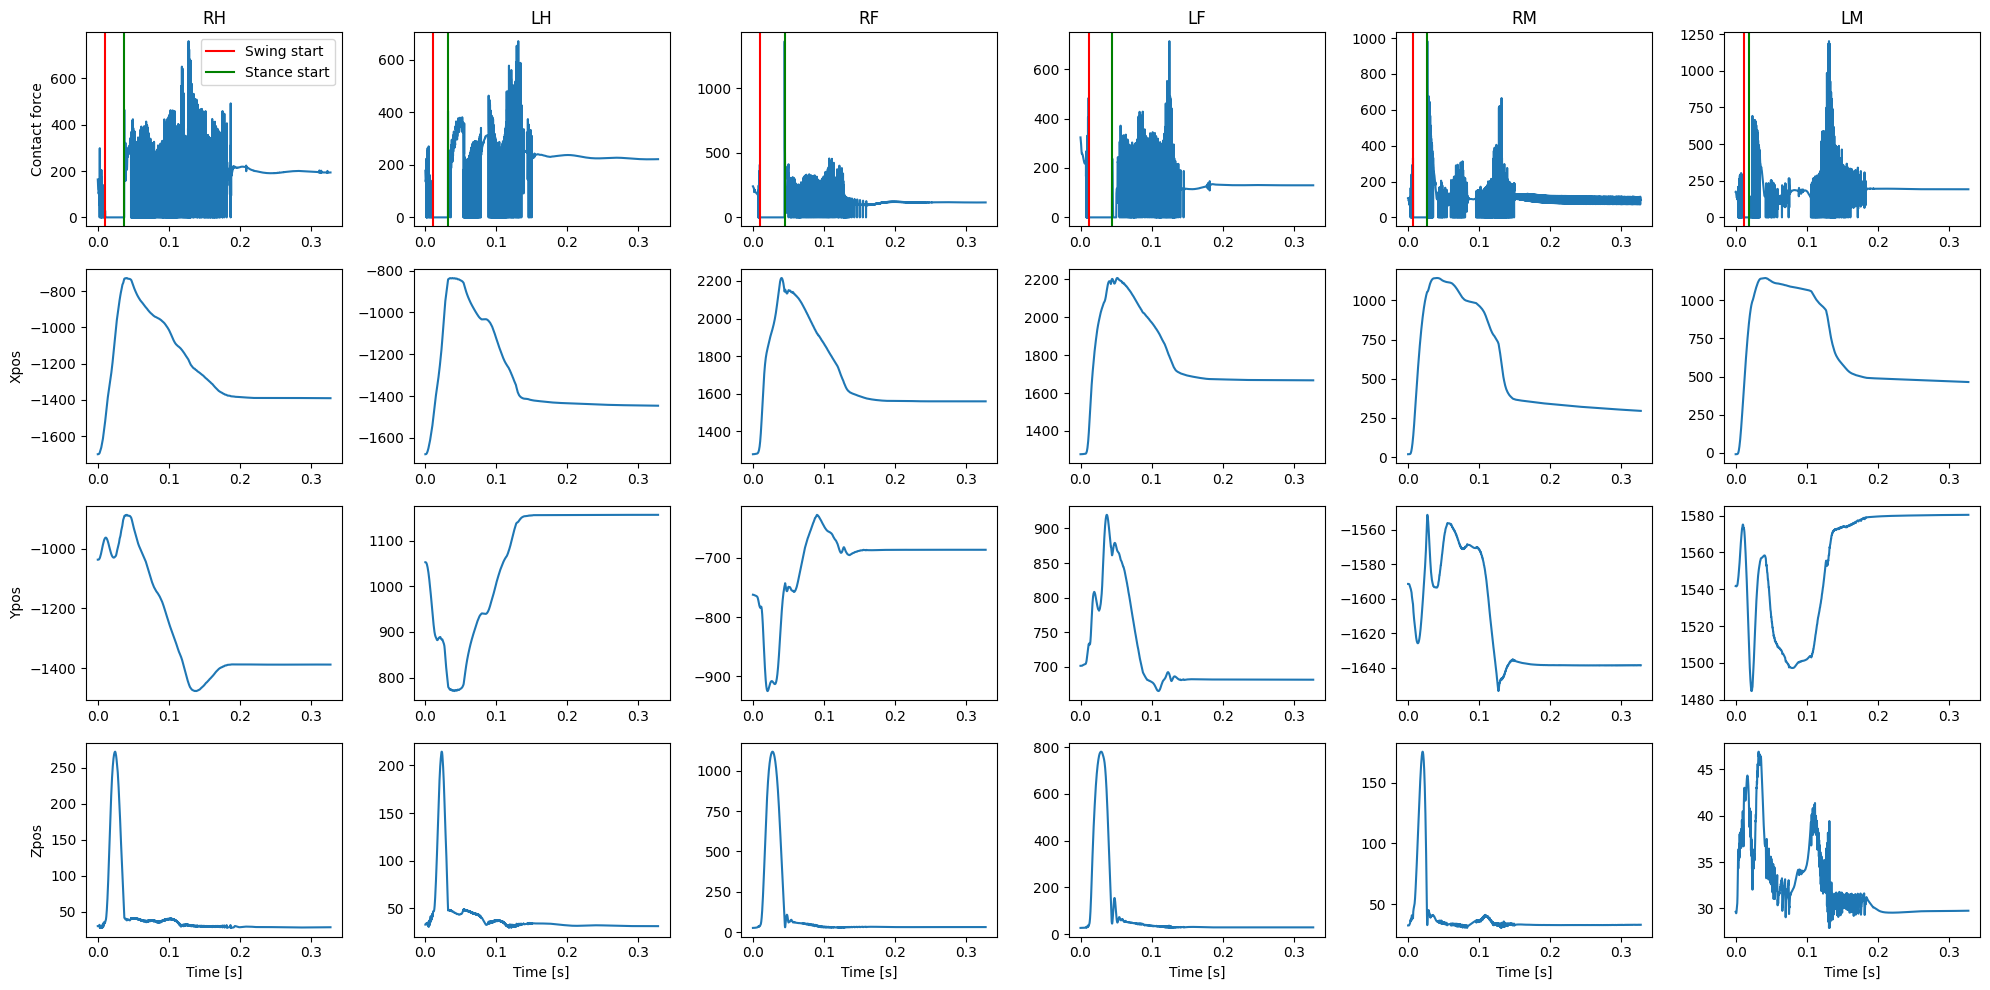

In [ ]:
fig, axs = plt.subplots(4, len(legs), figsize=(20, 10))
t = np.arange(touch_sensor_data.shape[1])*nmf.timestep

leg_swing_starts = {}
leg_stance_starts = {}

stride = 20 # Number of timesteps to check for contact
eps = 10 # Threshold for detecting contact

for i, leg in enumerate(legs):
    # Plot contact forces
    axs[0, i].plot(t, touch_sensor_data[i, :])
    k = 0
    # Until you find a swing onset keep going (as long as k is less than the length of the data)
    while k < len(touch_sensor_data[i]) and not np.all(touch_sensor_data[i, k:k+stride] == 0):
        k += 1
    swing_start = k
    if k < len(touch_sensor_data[i]):
        # Find the first time the contact force is above the threshold
        stance_start = np.where(touch_sensor_data[i, swing_start:] > eps)[0][0] + swing_start
        axs[0, i].axvline(t[swing_start], color='r', label="Swing start")
        axs[0, i].axvline(t[stance_start], color='g', label="Stance start")
        if i == 0:
            axs[0, i].legend()
        leg_swing_starts[leg] = swing_start
        leg_stance_starts[leg] = stance_start
    else:
        leg_swing_starts[leg] = 0
        leg_stance_starts[leg] = 0
        
    # Plot 3d coordinates of the last segment of the tarsus
    axs[1, i].plot(t, position_data[i, :, 0])
    axs[2, i].plot(t, position_data[i, :, 1])
    axs[3, i].plot(t, position_data[i, :, 2])
    axs[0, i].set_title(leg)
    if i == 0:
        axs[0, i].set_ylabel('Contact force')
        axs[1, i].set_ylabel('Xpos')
        axs[2, i].set_ylabel('Ypos')
        axs[3, i].set_ylabel('Zpos')
for j in range(len(legs)):
    axs[-1, j].set_xlabel('Time [s]')    

plt.tight_layout()

In [8]:
from ipywidgets import Video
Video.from_file(out_dir / 'video_steps.mp4')

FileNotFoundError: [Errno 2] No such file or directory: '..\\decentralized_ctrl\\video_steps.mp4'

In [ ]:
# Save the data, the step_timing and the number of stabilisation steps

with open(out_dir / "manual_corrected_data.pickle", 'wb') as handle:
    pickle.dump([step_data_block_manualcorrect, leg_swing_starts, leg_stance_starts, n_steps_stabil], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Approach based on timing 

Cruse rules are mostly formulated in terms of advancement in the leg state and contact forces. Contact forces are in general noisy in the simulation and depend on the initial stance. To start on flat terrain we could bypass the use of contact forces by admitting that a leg is repeatedly in stance or swing at some timepoints in the stepping. Those timepoints have been determined before when the fly was stepping in place

The main rules proposed by Cruse et al. can be formulated as:
- Rule 1: When one leg is in swing the coupled legs are inhibited (swing is the defined as the timepoint zero to the stance start)
- Rule 2: In the beginning of the stance period, coupled leg are encouraged to step (decreasing lineraly from stance start until the swing starts)
- Rule 3: When approaching the end of the stance coupled leg are forced to step (increasing linearly form stance start to swing start)

An easy way to represent those rules is to compute each leg contribution to the stepping of the coupled legs. Coupled legs are represented in a dictionnary. Stepping score is calculated for each leg, the leg that has the highest score initiate the stepping. If the leg is already in the stepping process, stepping is not be initiated. If mulitple legs have a very close score (within 0.1%) we can randomly decide which of these legs should step.

## Define helper variables

In [ ]:
# Initialize simulation
n_stabilisation_steps = n_steps_stabil
# Run the simulation for a few steps to stabilise the system before starting the contoller
num_steps = num_steps_base + n_stabilisation_steps

#Define rule variables
legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
leg_ids = np.arange(len(legs)).astype(int)
leg_corresp_id = dict(zip(legs, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

rule1_corresponding_legs = {"LH":["LM"], "LM":["LF"], "LF":[], "RH":["RM"], "RM":["RF"], "RF":[]}
rule2_corresponding_legs = {"LH":["LM", "RH"], "LM":["LF", "RM"], "LF":["RF"], "RH":["RM", "LH"], "RM":["RF", "LM"], "RF":["LF"]}
rule3_corresponding_legs = {"LH":["RH"], "LM":["LH", "RM"], "LF":["LM", "RF"], "RH":["LH"], "RM":["RH", "LM"], "RF":["LF", "RM"]}

#Rule 1 should supress lift off (if a leg is in swing coupled legs should not be lifted most important leg to guarantee stability)
rule1_weight = -1e4
#Rule 2 should facilitate early protraction (upon touchdown of a leg coupled legs are encouraged to swing)
rule2_weight = 2.5
rule2_weight_contralateral = 1
#Rule 3 should enforce late protraction (the later in the stance the more it facilitates stance initiation)
rule3_weight = 3
rule3_weight_contralateral = 2

# This represents the score of each leg in the current step
leg_scores = np.zeros(len(legs))
all_leg_scores = np.zeros((len(legs), num_steps))

# Monitor the evolution of each part of the score for each leg
all_legs_rule1_scores = np.zeros((len(legs), num_steps))
all_legs_rule2_scores = np.zeros((len(legs), num_steps))
all_legs_rule3_scores = np.zeros((len(legs), num_steps))

# one percent margin if leg score within this margin to the max score random choice between the very likely legs
percent_margin = 0.001

# For each leg the ids of the force sensors that are attached to it
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.collision_tracked_geoms):
    for leg in legs:
        if collision_geom.startswith(leg):
            leg_force_sensors_ids[leg].append(i)   

## Define helper functions

In [ ]:
def update_stepping_advancement(stepping_advancement, legs, interp_step_duration):
    # Advance the stepping advancement of each leg that are stepping, reset the advancement of the legs that are done stepping
    for k, leg in enumerate(legs):
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
    return stepping_advancement

def compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                       rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                       rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                       stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration):
    # Compute the leg scores for the current  timestep based on the rules and the stepping advancement
    # Fills the global variables all_legs_rule1_scores, all_legs_rule2_scores, all_legs_rule3_scores, all_leg_scores to monitor the evolution of the score (debugging)
    leg_scores = np.zeros(len(legs))
    
    #Iterate through legs to compute score
    for k, leg in enumerate(legs):        
        # For the first rule
        leg_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]]] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)
        all_legs_rule1_scores[[leg_corresp_id[l] for l in rule1_corresponding_legs[leg]], i] += rule1_weight*(stepping_advancement[k]>0 and stepping_advancement[k]<leg_stance_starts[leg]).astype(float)       
        
        #For the second rule strong contact force happens at the beggining of the stance phase
        for l in rule2_corresponding_legs[leg]:
            #Decrease with stepping advancement
            if l[0] == leg[0]:
                #ipsilateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                #contralateral leg
                leg_scores[leg_corresp_id[l]] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule2_scores[leg_corresp_id[l], i] += rule2_weight_contralateral*((interp_step_duration - leg_stance_starts[leg])-(stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

        #For the third rule
        for l in rule3_corresponding_legs[leg]:
            #Increase with stepping advancement
            if l[0] == leg[0]:
                leg_scores[leg_corresp_id[l]] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
            else:
                leg_scores[leg_corresp_id[l]] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0
                all_legs_rule3_scores[leg_corresp_id[l], i] += rule3_weight_contralateral*((stepping_advancement[k] - leg_stance_starts[leg])) if (stepping_advancement[k] - leg_stance_starts[leg])>0 else 0

    return leg_scores

## Run the simulation

In [ ]:
np.random.seed(42)

# This serves to keep track of the advancement of each leg in the stepping sequence
stepping_advancement = np.zeros(len(legs)).astype(int)

nmf.reset()

# Track the number of steps taken. It will be used to determine the stpping probability in the random stepper
number_of_taken_steps = 0
leg_scores = np.zeros(len(legs))

obs_list_cruse_flat = []
all_initiated_legs = []

#Run the actual simulation
for i in trange(num_steps):

    #Decide in which leg to step
    initiating_leg = np.argmax(leg_scores)
    within_margin_legs = leg_scores[initiating_leg]-leg_scores <= leg_scores[initiating_leg]*percent_margin

    # If multiple legs are within the margin choose randomly among those legs
    if np.sum(within_margin_legs) > 1:
        initiating_leg = np.random.choice(np.where(within_margin_legs)[0])

    # If the maximal score is zero or less (except for the first step after stabilisation to initate the locomotion) or if the leg is already stepping
    if (leg_scores[initiating_leg] <= 0 and not i == n_stabilisation_steps+1) or stepping_advancement[initiating_leg] > 0:
        initiating_leg = None
    else:
        stepping_advancement[initiating_leg] += 1
        all_initiated_legs.append([initiating_leg, i])
        number_of_taken_steps += 1
        #print("Stepping leg: ", legs[initiating_leg], " at step: ", i)
    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list_cruse_flat.append(obs)

    stepping_advancement = update_stepping_advancement(stepping_advancement, legs, interp_step_duration)

    leg_scores = compute_leg_scores(rule1_corresponding_legs, rule1_weight,
                                    rule2_corresponding_legs, rule2_weight, rule2_weight_contralateral,
                                    rule3_corresponding_legs, rule3_weight, rule3_weight_contralateral,
                                    stepping_advancement, leg_corresp_id, leg_stance_starts, interp_step_duration)
        
    all_leg_scores[:, i] = leg_scores

nmf.save_video(out_dir / "cruse_flat.mp4")
nmf.close()

distances = obs_list_cruse_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_cruse_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])

100%|██████████| 14792/14792 [00:26<00:00, 551.20it/s]


Forward distance travelled:  -7574.344732036973
Lateral distance travelled:  -385.46467057151045


## Visualize the leg score

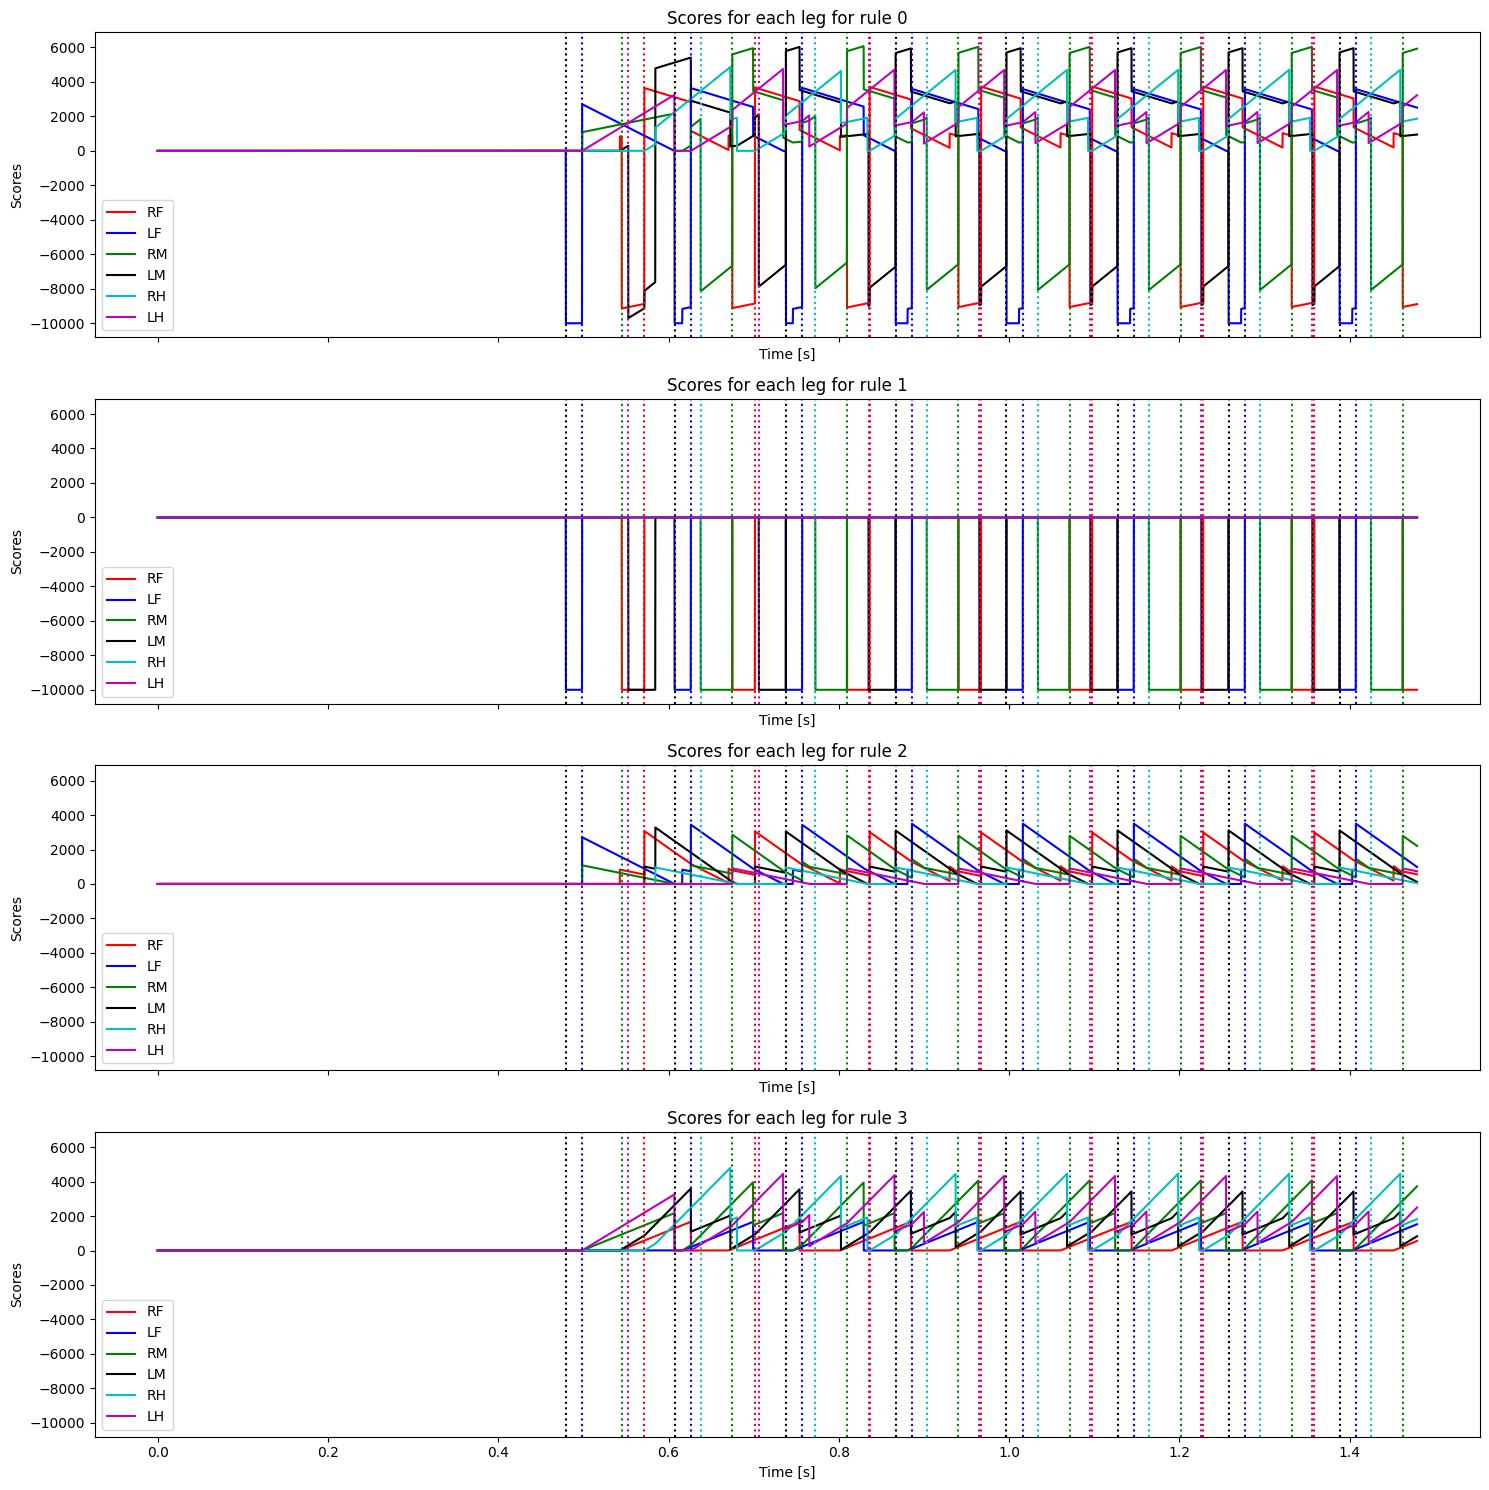

In [ ]:
# Plot the evolution of the scores for each leg
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True, sharey=True)

t_ids = np.arange(0, num_steps, 1)
time = t_ids*nmf.timestep

leg_of_interest = ["RF", "LF", "RM", "LM", "RH", "LH"]
colors = ["r", "b", "g", "k", "c", "m"]
j_ids = np.tile([legs.index(leg) for leg in leg_of_interest], (len(t_ids), 1)).T

for a, (ax, rule_score) in enumerate(zip(axs, [all_leg_scores[j_ids, t_ids], all_legs_rule1_scores, all_legs_rule2_scores, all_legs_rule3_scores])):
    for i, l_score in enumerate(rule_score[j_ids, t_ids]):
        if i ==0:
            ax.set_title("Scores for each leg")
        else:
            ax.set_title("Scores for each leg for rule "+str(a))
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Scores")

        ax.plot(time, l_score, c=colors[i], linestyle="-", label=leg_of_interest[i])
    
    for leg_id, step in all_initiated_legs:
        color_index = leg_of_interest.index(legs[leg_id])
        #print(color_index, step)
        ax.axvline(time[step], color=colors[color_index], linestyle=":")
    ax.legend()

fig.tight_layout()
plt.show()

Finally, we inspect the video:

In [ ]:
from ipywidgets import Video
Video.from_file(out_dir / 'cruse_flat.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

## Plot gait diagram

The gait diagram is a common visualization when studying locomotion. It simplifies the visualization of coordination between legs. Stance periods are shown in black while swing timepoints are shown in white.

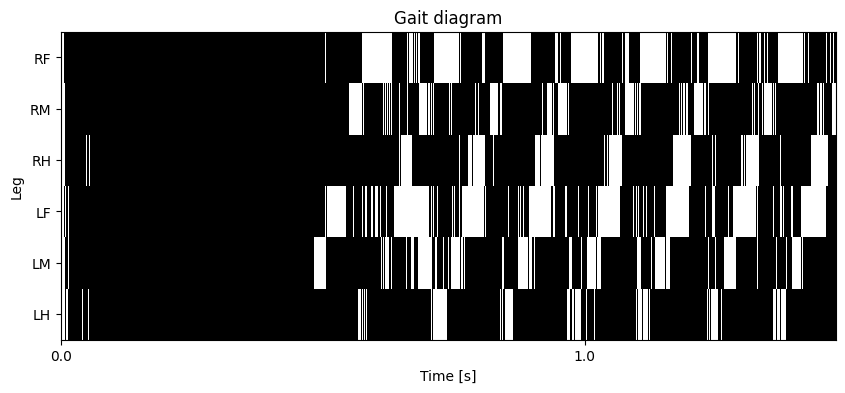

In [ ]:
# plot the gait diagram

# Build an where lines are legs, columns are timepoint and there is a one in the array if the left leg is in contact with the ground
# and a zero if it is not
all_legs_contact = np.zeros((len(legs), num_steps))
gait_diagram_leg_order = ["RF", "RM", "RH", "LF", "LM", "LH"]

assert set(gait_diagram_leg_order) == set(legs)

for t in range(num_steps):
    for l, leg in enumerate(gait_diagram_leg_order):
        all_legs_contact[l, t] = np.sum(obs_list_cruse_flat[t]["contact_forces"][leg_force_sensors_ids[leg]]) > 0

# plot the gait diagram leg vs time; Should appear black if the leg is in contact with the ground
# median filter the contat to smooth the gait diagram

from scipy.signal import medfilt

plt.figure(figsize=(10, 4))
#all_legs_contact_smooth = medfilt(all_legs_contact, kernel_size=(1, 3))
plt.imshow((np.logical_not(all_legs_contact)), cmap="gray", aspect="auto", interpolation="none")
plt.xlabel("Time [s]")
plt.ylabel("Leg")
plt.yticks(np.arange(len(legs)), gait_diagram_leg_order)
plt.xticks(t_ids[::10000], time[::10000])
plt.title("Gait diagram")
plt.show()

The gait implemented by the fly with a random seed of 32 is not a classical gait used by the fly. It is very close to a trot gait (Front and contralateral hindleg swinging together) used by some quadrupeds with some additional midleg movements. In this simulation the fly's midleg is stepping just after the ipsilateral hindleg.

The tripod gait is the canonical gait used by flies. It is the fastest and most stable gait the fly is using. You can learn more about it in [DeAngelis et al. (2019)](https://elifesciences.org/articles/46409#content) and [Ramdya et al. (2017)](https://www.nature.com/articles/ncomms14494). How would you need to modify the Cruse rules to get a tripod gait ?

# Compare with random controller

In [ ]:
np.random.seed(42)
#Comparison with random is interesting but probability of stepping should be the same

p_step = (number_of_taken_steps)/(num_steps-n_stabilisation_steps)*1.3 # stepping probability with 30% more to give an advantage to the random controller

nmf.reset()

stepping_advancement = np.zeros(len(legs)).astype(int)

obs_list_random_flat = []
n_step_random_taken = 0
n_late_steps = 0

#Run the actual simulation
for i in trange(num_steps):

    # Decide if going to step or not
    p = np.random.rand()
    if i > n_stabilisation_steps and p<p_step:
        #Decide in which leg to step if all legs are already stepping increment late step counter
        try:
            initiating_leg = np.random.choice(leg_ids[stepping_advancement <= 0])
            n_step_random_taken += 1
            stepping_advancement[initiating_leg] += 1
        except:
            n_late_steps += 1
    
    if n_late_steps > 0 and np.any(stepping_advancement <= 0):
        # If some step could not have been perfomed previously, we an perfom them as soon as the steppinf advancement is zero
        initiating_leg = np.random.choice(leg_ids[stepping_advancement <= 0])
        n_step_random_taken += 1
        stepping_advancement[initiating_leg] += 1
        n_late_steps -= 1

    
    joint_pos = step_data_block_manualcorrect[joint_ids, stepping_advancement[match_leg_to_joints]]
    action = {'joints': joint_pos,  'adhesion': np.zeros(6)}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list_random_flat.append(obs)

    #Compute score and update stepping advancement
    leg_scores = np.zeros(len(legs))
    for k, leg in enumerate(legs):
        #Update_the_stepping_advancement
        if stepping_advancement[k] >= interp_step_duration-1:
            stepping_advancement[k] = 0
        elif stepping_advancement[k] > 0:
            stepping_advancement[k] +=1
        
    all_leg_scores[:, i] = leg_scores

distances = obs_list_random_flat[n_stabilisation_steps]["fly"][0][:2] - obs_list_random_flat[-1]["fly"][0][:2]
print("Forward distance travelled: ", distances[0])
print("Lateral distance travelled: ", distances[1])   

print("Target number of steps: ", number_of_taken_steps, "\n"
      "Number of steps taken by random: ", n_step_random_taken)

nmf.save_video(out_dir / 'random_flat.mp4')
#nmf.close()

100%|██████████| 14792/14792 [00:25<00:00, 570.99it/s]


Forward distance travelled:  -5663.612322727088
Lateral distance travelled:  -650.21701848429
Target number of steps:  45 
Number of steps taken by random:  44


In [6]:
Video.from_file(out_dir / 'random_flat.mp4')

NameError: name 'Video' is not defined

Note that in most cases a random controller is not terrible. A six legged animal is very stable and hard to tip over. That said its efficiency is much lower than a coordinated controller. One could look at the energy expenditure by the two controllers. An efficient controller should to some extend minimize the energy consumption ...